# Measuring static ZZ coupling
> @author: Jiheng Duan, Pan Shi

## About

This document will tell you how to scan, measure, and calculating the ZZ coupling strength.

### Required Import

**The following thing must be import.**

In the current folder (despite `~\Tutorial\arb_qubit_tutorial\`), the system structure are based on file `~\System\transmon_system.py`. For using arbitrary qubit system structure, please move to the demonstration file under `~\Tutorial\arb_qubit_tutorial\`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
# # This on is a path correcting code, which is used to find the path of qusim.
# sys.path.append('../..')

import qusim.System.transmon_system as qs
# Some useful tools
import qusim.Instruments.tools as tools
# Some intrinsic plotting function
import qusim.DataPlot.plot_lib as pl

### Optional import

**The following import are optional**

In [2]:
# Print the full output
np.set_printoptions(threshold=sys.maxsize)

# auto reload
%load_ext autoreload
%autoreload 2 

# variable name -> string
def var_name2str(variable):
    def nested_var_name2str(value):
        if isinstance(value, list):
            return [nested_var_name2str(item) for item in value]
        else:
            for name in globals():
                if eval(name) == value:
                    return name
            return str(value)
    return nested_var_name2str(variable)

## Mathematical formulism

The static ZZ coupling between two subsystem that shifts the their energy levels. For instance, for two qubits, the energy relation $E_{11} + E_{00} = E_{01} + E_{10}$ should be valid. But due to the static ZZ interaction, the relation will not hold as the each qubit's frequency is slightly shifter due to the coupling term: $\xi_{12}/2 \sigma_{z,1} \sigma_{z,2}$.

The ZZ coupling strength is defined as
$$
\xi = E_{11} + E_{00} - E_{10} - E_{01}
$$

In the Transmon-Coupler-Transmon case:
$$
\xi = E_{101} + E_{000} - E_{100} - E_{001}
$$

### Define system parameters

In [5]:
N = None # Maximum excitation level
w = [7, 5, 6.6] # Qubit frequency
q_dim = [4 for _ in range(len(w))]
alpha =[-0.24, -0.14, -0.24] # Anharmonicity
r_dic = {
    "r12": 0.11,
    "r13": -0.006,
    "r23": 0.11
}
r = tools.r2matrix(r_dic, w) # Coupling strength
gamma_list = None # Gamma up, Gamma down, Gamma z

### Define the scanning parameters

Here, we want to scan the coupler frequency to find a trade off between Transmon frequency, coupler frequency, and the ZZ coupling.

In [6]:
# Define scanning space
w2_scan_space = np.linspace(5, 8, 41)
w3_scan_space = np.linspace(6.6, 7.4, 11)

Then, we write a double for loop, which scan the 2nd qubit first, and the inner loop is iterating the coupler frequency. Notice that we change the corresponding frequency by just defining the frequency list `w_scan` by `[w[0], w[1], w3]` and `[w[0], w2, w3]`, respective.

Notice that we set up the qubit system twice, where we get the state index first, and use that index to find the state in the second loop.

In [7]:
# Scanning
zz_list = []

for w3 in w3_scan_space:
    zz_dummy_list = []
    w = [w[0], w[1], w3]
    zz_system1 = qs.TransmonSys(N, q_dim, w, alpha, r, gamma_list)
    # State represented in tuple, e.g., |100> ==> (1,0,0)
    index_101 = zz_system1.get_state_index((1,0,1))
    index_100 = zz_system1.get_state_index((1,0,0))
    index_001 = zz_system1.get_state_index((0,0,1))
    index_000 = zz_system1.get_state_index((0,0,0))
    
    for w2 in w2_scan_space:
        w_scan = [w[0], w2, w3]
        zz_system2 = qs.TransmonSys(N, q_dim, w_scan, alpha, r, gamma_list)
        E_101 = zz_system2.H.eigenenergies()[index_101]/np.pi/2
        E_100 = zz_system2.H.eigenenergies()[index_100]/np.pi/2
        E_001 = zz_system2.H.eigenenergies()[index_001]/np.pi/2
        E_000 = zz_system2.H.eigenenergies()[index_000]/np.pi/2
        
        zz_dummy_list.append((- E_101 + E_100 + E_001 - E_000).real)
    zz_list.append(zz_dummy_list)

### Plot ZZ

Notice that the unit in frequency is GHz

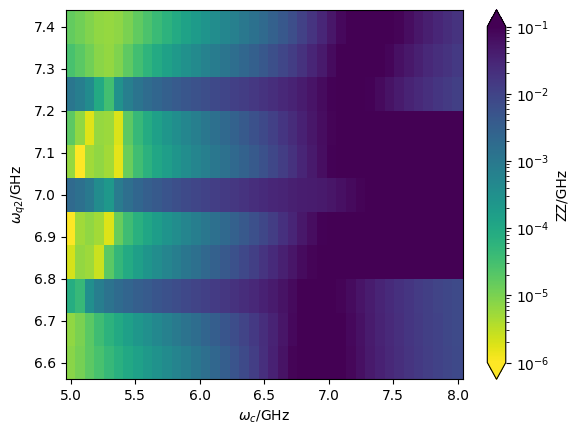

0

In [8]:
x_list, y_list = np.meshgrid(w2_scan_space, w3_scan_space)
zz_list=np.abs(zz_list)

%matplotlib inline
pl.plot_zz_sweep(x_list, y_list, zz_list, "\omega_c", "\omega_{q2}")